Epoch 1/500, Test accuracy: 0.7373
Epoch 2/500, Test accuracy: 0.7288
Epoch 3/500, Test accuracy: 0.7938
Epoch 4/500, Test accuracy: 0.7938
Epoch 5/500, Test accuracy: 0.7740
Epoch 6/500, Test accuracy: 0.8079
Epoch 7/500, Test accuracy: 0.7938
Epoch 8/500, Test accuracy: 0.7994
Epoch 9/500, Test accuracy: 0.7938
Epoch 10/500, Test accuracy: 0.8136
Epoch 11/500, Test accuracy: 0.8164
Epoch 12/500, Test accuracy: 0.7938
Epoch 13/500, Test accuracy: 0.8079
Epoch 14/500, Test accuracy: 0.8051
Epoch 15/500, Test accuracy: 0.8079
Epoch 16/500, Test accuracy: 0.8446
Epoch 17/500, Test accuracy: 0.8164
Epoch 18/500, Test accuracy: 0.8220
Epoch 19/500, Test accuracy: 0.8362
Epoch 20/500, Test accuracy: 0.8192
Epoch 21/500, Test accuracy: 0.8079
Epoch 22/500, Test accuracy: 0.8107
Epoch 23/500, Test accuracy: 0.8249
Epoch 24/500, Test accuracy: 0.8164
Epoch 25/500, Test accuracy: 0.8164
Epoch 26/500, Test accuracy: 0.8192
Epoch 27/500, Test accuracy: 0.8136
Epoch 28/500, Test accuracy: 0.8362
E

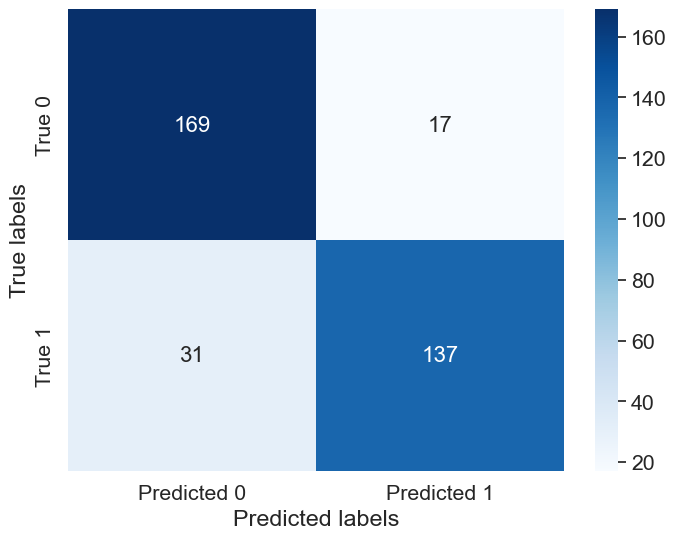

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix

# Read the data from the CSV file
file_path = "combined_final_test.csv"
df = pd.read_csv(file_path)

# Ensure a balanced dataset by selecting an equal number of samples from each class
min_class_samples = min(df['true_label'].value_counts())
class_0_samples = df[df['true_label'] == 0].sample(min_class_samples, random_state=42)
class_1_samples = df[df['true_label'] == 1].sample(min_class_samples, random_state=42)
balanced_df = pd.concat([class_0_samples, class_1_samples], ignore_index=True)

# Extract features (model accuracies) and target (true labels)
X = balanced_df.iloc[:, :-1].values / 100.0  # Normalize the features to the range [0, 1]
y = balanced_df['true_label'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).view(-1, 1)

# Define the neural network model with increased depth and neurons, and dropout
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 1024)
        self.relu1 = nn.LeakyReLU(0.2)
        self.batch_norm1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(1024, 512)
        self.relu2 = nn.LeakyReLU(0.2)
        self.batch_norm2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.4)

        self.fc3 = nn.Linear(512, 256)
        self.relu3 = nn.LeakyReLU(0.2)
        self.batch_norm3 = nn.BatchNorm1d(256)
        self.dropout3 = nn.Dropout(0.3)

        self.fc4 = nn.Linear(256, 128)
        self.relu4 = nn.LeakyReLU(0.2)
        self.batch_norm4 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(0.2)

        self.fc5 = nn.Linear(128, 64)
        self.relu5 = nn.LeakyReLU(0.2)
        self.batch_norm5 = nn.BatchNorm1d(64)
        self.dropout5 = nn.Dropout(0.2)

        self.fc6 = nn.Linear(64, 32)
        self.relu6 = nn.LeakyReLU(0.2)
        self.batch_norm6 = nn.BatchNorm1d(32)
        self.dropout6 = nn.Dropout(0.1)

        self.fc7 = nn.Linear(32, 16)
        self.relu7 = nn.LeakyReLU(0.2)
        self.batch_norm7 = nn.BatchNorm1d(16)
        self.dropout7 = nn.Dropout(0.1)

        self.fc_final = nn.Linear(16, 1)  # Adjusted output size to match the final layer in your TensorFlow model
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.dropout1(self.batch_norm1(self.relu1(self.fc1(x))))
        x = self.dropout2(self.batch_norm2(self.relu2(self.fc2(x))))
        x = self.dropout3(self.batch_norm3(self.relu3(self.fc3(x))))
        x = self.dropout4(self.batch_norm4(self.relu4(self.fc4(x))))
        x = self.dropout5(self.batch_norm5(self.relu5(self.fc5(x))))
        x = self.dropout6(self.batch_norm6(self.relu6(self.fc6(x))))
        x = self.dropout7(self.batch_norm7(self.relu7(self.fc7(x))))
        x = self.sigmoid(self.fc_final(x))
        return x

# Instantiate the model, define loss function and optimizer
model = CustomModel()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Adding weight regularization

# Training the model
epochs = 500
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        y_pred_prob_tensor = model(X_test_tensor)
        y_pred_tensor = (y_pred_prob_tensor >= 0.5).float()

    test_accuracy = torch.sum(y_pred_tensor == y_test_tensor).item() / len(y_test_tensor)
    print(f"Epoch {epoch + 1}/{epochs}, Test accuracy: {test_accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tensor.numpy())

# Heatmap
df_cm = pd.DataFrame(cm, index=["True 0", "True 1"], columns=["Predicted 0", "Predicted 1"])
plt.figure(figsize=(8, 6))
sn.set(font_scale=1.4)  # for label size
sn.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# Save the model
torch.save(model.state_dict(), 'advanced_model.pth')


Test accuracy: 0.8502824858757062


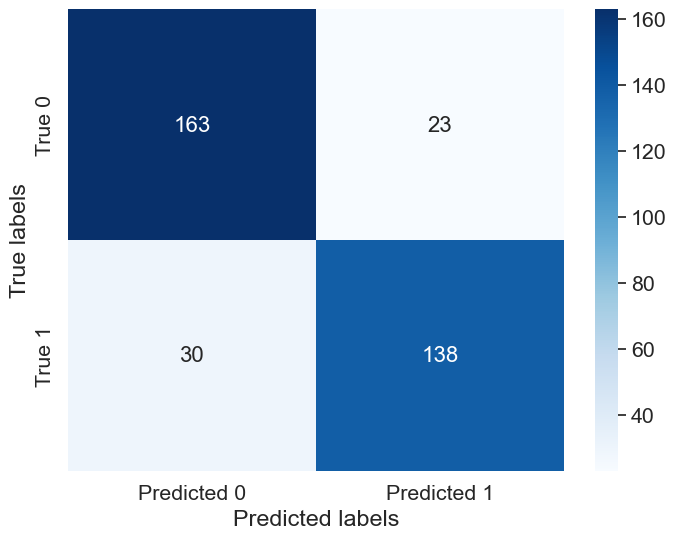

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix

# Read the data from the CSV file
file_path = "combined_final_test.csv"
df = pd.read_csv(file_path)

# Ensure a balanced dataset by selecting an equal number of samples from each class
min_class_samples = min(df['true_label'].value_counts())
class_0_samples = df[df['true_label'] == 0].sample(min_class_samples, random_state=42)
class_1_samples = df[df['true_label'] == 1].sample(min_class_samples, random_state=42)
balanced_df = pd.concat([class_0_samples, class_1_samples], ignore_index=True)

# Extract features (model accuracies) and target (true labels)
X = balanced_df.iloc[:, :-1].values / 100.0  # Normalize the features to the range [0, 1]
y = balanced_df['true_label'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).view(-1, 1)

# Define the neural network model
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 512)
        self.relu1 = nn.LeakyReLU(0.2)
        self.batch_norm1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(512, 256)
        self.relu2 = nn.LeakyReLU(0.2)
        self.batch_norm2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.4)

        self.fc3 = nn.Linear(256, 128)
        self.relu3 = nn.LeakyReLU(0.2)
        self.batch_norm3 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(0.3)

        self.fc4 = nn.Linear(128, 64)
        self.relu4 = nn.LeakyReLU(0.2)
        self.batch_norm4 = nn.BatchNorm1d(64)
        self.dropout4 = nn.Dropout(0.2)

        self.fc5 = nn.Linear(64, 32)
        self.relu5 = nn.LeakyReLU(0.2)
        self.batch_norm5 = nn.BatchNorm1d(32)
        self.dropout5 = nn.Dropout(0.2)

        self.fc6 = nn.Linear(32, 16)
        self.relu6 = nn.LeakyReLU(0.2)
        self.batch_norm6 = nn.BatchNorm1d(16)
        self.dropout6 = nn.Dropout(0.1)

        self.fc7 = nn.Linear(16, 8)
        self.relu7 = nn.LeakyReLU(0.2)
        self.batch_norm7 = nn.BatchNorm1d(8)
        self.dropout7 = nn.Dropout(0.1)

        self.fc_final = nn.Linear(8, 1)  # Adjusted output size to match the final layer in your TensorFlow model
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.dropout1(self.batch_norm1(self.relu1(self.fc1(x))))
        x = self.dropout2(self.batch_norm2(self.relu2(self.fc2(x))))
        x = self.dropout3(self.batch_norm3(self.relu3(self.fc3(x))))
        x = self.dropout4(self.batch_norm4(self.relu4(self.fc4(x))))
        x = self.dropout5(self.batch_norm5(self.relu5(self.fc5(x))))
        x = self.dropout6(self.batch_norm6(self.relu6(self.fc6(x))))
        x = self.dropout7(self.batch_norm7(self.relu7(self.fc7(x))))
        x = self.sigmoid(self.fc_final(x))
        return x

# Instantiate the model, define loss function and optimizer
model = CustomModel()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 500
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Evaluation on test data
model.eval()
with torch.no_grad():
    y_pred_prob_tensor = model(X_test_tensor)
    y_pred_tensor = (y_pred_prob_tensor >= 0.5).float()

test_accuracy = torch.sum(y_pred_tensor == y_test_tensor).item() / len(y_test_tensor)
print("Test accuracy:", test_accuracy)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tensor.numpy())

# Heatmap
df_cm = pd.DataFrame(cm, index=["True 0", "True 1"], columns=["Predicted 0", "Predicted 1"])
plt.figure(figsize=(8, 6))
sn.set(font_scale=1.4)  # for label size
sn.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# Save the model
torch.save(model.state_dict(), 'advanced_model.pth')


Test accuracy: 0.6101694703102112


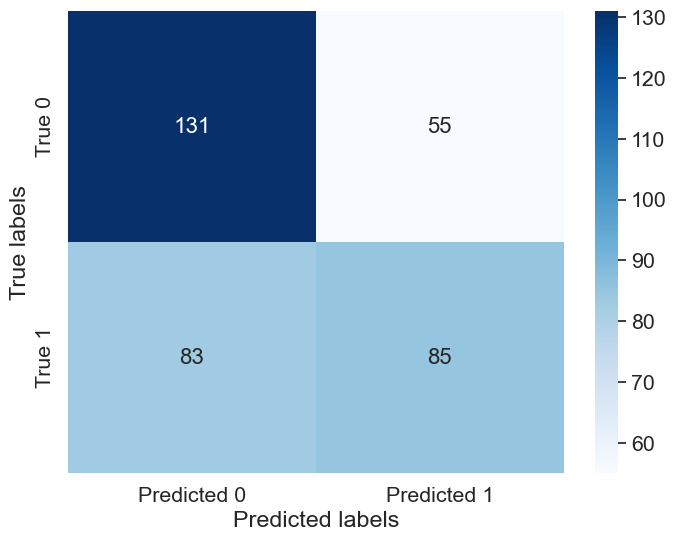

In [10]:

# Make predictions on test data and evaluate accuracy
model.eval()
with torch.no_grad():
    y_pred_prob = model(X_test)
y_pred = (y_pred_prob >= 0.5).to(torch.int).flatten()
test_accuracy = torch.sum(y_pred == y_test) / len(y_test)
print("Test accuracy:", test_accuracy.item())

# Confusion Matrix
cm = confusion_matrix(y_test.numpy(), y_pred.numpy())

# Heatmap
df_cm = pd.DataFrame(cm, index=["True 0", "True 1"], columns=["Predicted 0", "Predicted 1"])
plt.figure(figsize=(8, 6))
sn.set(font_scale=1.4)  # for label size
sn.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


In [ ]:

# Continue with the rest of your code (e.g., saving the model)
torch.save(model.state_dict(), 'advanced_model.pth')


In [ ]:

# Load the saved model
loaded_model = AdvancedModel(input_size)
loaded_model.load_state_dict(torch.load('advanced_model.pth'))

# Assuming you have a new set of inputs in a NumPy array
new_inputs = np.array([[...], [...], ...])  # Replace this with your actual input data

# Normalize the new inputs (if normalization was applied during training)
new_inputs = new_inputs / 100  # Adjust the normalization based on your training data

# Convert inputs to PyTorch tensor
new_inputs_tensor = torch.FloatTensor(new_inputs)

# Make predictions
with torch.no_grad():
    predictions = loaded_model(new_inputs_tensor)

# Convert predictions to binary (0 or 1) based on a threshold (e.g., 0.5)
binary_predictions = (predictions >= 0.5).to(torch.int).flatten()

print("Predictions:", binary_predictions.numpy())

# Accuracy dictionary
accuracy_dict = {'model_84_acc_10_frames_final_data': 0.02392133610555902,
                 'model_87_acc_20_frames_final_data': 8.432866138718964e-05,
                 'model_89_acc_40_frames_final_data': 3.6262814973042623e-06,
                 'model_90_acc_20_frames_FF_data': 99.92972612380981,
                 'model_90_acc_60_frames_final_data': 1.44013698744061e-06,
                 'model_93_acc_100_frames_celeb_FF_data': 0.02802633389364928,
                 'model_95_acc_40_frames_FF_data': 97.99904823303223,
                 'model_97_acc_60_frames_FF_data': 99.99699592590332,
                 'model_97_acc_80_frames_FF_data': 99.8922348022461,
                 'model_97_acc_100_frames_FF_data': 99.52414035797119}

# Assuming 'true_label' is the last element in your order
model_names = list(accuracy_dict.keys())
model_accuracies = np.array(list(accuracy_dict.values()))

# Normalize accuracies to obtain probabilities
probabilities = model_accuracies / 100.0  # Assuming accuracies are in percentage format

# Reshape the probabilities to match the model input shape
new_inputs_tensor = torch.FloatTensor(probabilities.reshape(1, -1))

# Make predictions
with torch.no_grad():
    predictions = loaded_model(new_inputs_tensor)

print("Predictions:", predictions.item())


NameError: name 'AdvancedModel' is not defined

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, optimizers, regularizers
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix


12/12 [==============================] - 2s 2ms/step
Test accuracy: 0.8986301369863013


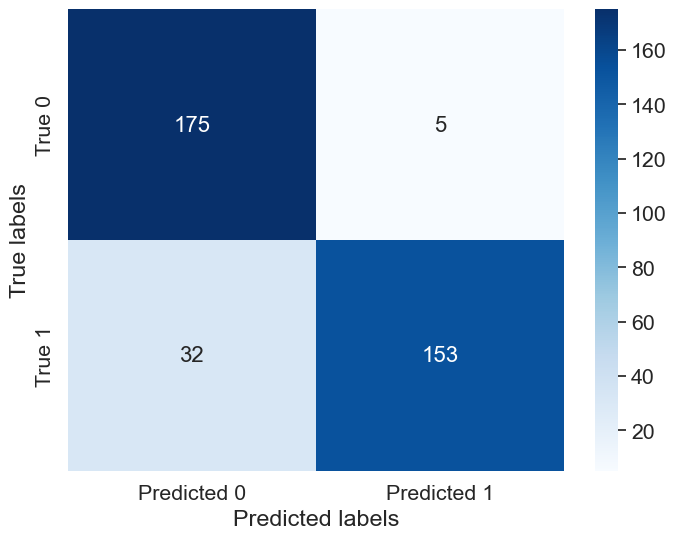

In [ ]:

model = keras.models.load_model('advanced_model.h5')

# Make predictions on test data and evaluate accuracy
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()
test_accuracy = sum(y_pred == y_test) / len(y_test)
print("Test accuracy:", test_accuracy)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Heatmap
df_cm = pd.DataFrame(cm, index=["True 0", "True 1"], columns=["Predicted 0", "Predicted 1"])
plt.figure(figsize=(8, 6))
sn.set(font_scale=1.4)  # for label size
sn.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
